# 라이브러리 및 데이터 로드

In [ ]:
import numpy as np
import pandas as pd
import warnings
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from itertools import repeat
from time import perf_counter
from tensorflow.keras.metrics import BinaryAccuracy, AUC

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
pd.set_option('display.max_columns', None)
tf.keras.backend.set_floatx('float32')

# 전처리 코드

논문 번역 발췌
- χ
> 유저와 아이템을 묶는 m-fields(종류)로 구성
> 범주형 field(e.g. 성별, 위치)를 포함할 수도 있고 연속형 field(e.g. 나이)를 포함

- y
> 유저가 클릭을 했는지 안 했는지의 데이터가 0,1로 라벨링  

- 각각의 범주형 field는 one-hot vector로 표현
- 각각의 연속형 field는 값 자체로 표현되거나 이산화(discretization)한 뒤에 one-hot encdoing을 하여 표현.

- 그런 다음 각각의 데이터는 ( 𝑥 ,y) shape으로 바뀌는데  𝑥  = [ $𝑥_{𝑓𝑖𝑒𝑙𝑑1} , 𝑥_{𝑓𝑖𝑒𝑙𝑑2} , ... ,  𝑥_{𝑓𝑖𝑒𝑙𝑑𝑗} ,... ,  𝑥_{𝑓𝑖𝑒𝑙𝑑𝑚}$ ] 이고 
d차원의 벡터  
- $𝑥_{𝑓𝑖𝑒𝑙𝑑𝑗}$  는  𝜒  의 j번째 field를 나타낸다. 
- 보통 x는 매우 차원이 높고 극도로 sparse하다.

In [ ]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 10

def data_split():
    cols = {'obj': [],
        'cat': [],
       'cont': []
        }

    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        # if 'category' in dt_idx:
        #     df[['category1']] = LabelEncoder().fit_transform(df[['category1']])
        #     cols['cat'].append('category1')

        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

In [ ]:
def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
def preprocessing():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)
    # 데이터 유형별 분류하기
    data = reorganization(df)
    # cols = data_split()
    modified_df = pd.DataFrame()
    vec_dict = {idx: [] for idx in range(len(data.columns))}
    feature_index = []

    for i, c in enumerate(data.columns):
        if c in cols['obj']:
            obj_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
            modified_df = pd.concat([modified_df, obj_data], axis=1)
            vec_dict[i] = list(obj_data.columns)
            feature_index.extend(repeat(i, obj_data.shape[1]))

        elif c in cols['cat']:  # click_label 컬럼 = y 변수로 사용
            if 'click' in c:
                pass
            else:
                cat_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
                vec_dict[i] = list(cat_data.columns)
                feature_index.extend(repeat(i, cat_data.shape[1]))
                modified_df = pd.concat([modified_df, cat_data], axis=1)
        else:
            scaled_num_data = MinMaxScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)
            vec_dict[i] = list(scaled_num_data.columns)
            feature_index.extend(repeat(i, scaled_num_data.shape[1]))

    print('---- Data info ----')
    print(cols)
    print('Data Frame shape: {}'.format(modified_df.shape))
    print('# of Feature: {}'.format(len(feature_index)))
    print(f'# of Field: {len(vec_dict)}')
    print(f'Modified DF columns: {modified_df.columns}')
    # print(vec_dict)
    return vec_dict, feature_index, modified_df

In [ ]:
# vec_dict, feature_index, modified_df = preprocessing()

In [ ]:
# modified_df.head(3)

# 모델링을 위한 데이터 분리하기

In [ ]:
# 데이터 7:3으로 나누기 (혹은 8:2)
def split_data():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    vec_dict, feature_index, modified_df = preprocessing()

    X = modified_df#.astype('float')
    y = df['click_label']

    print(f"X features' name (10): {X.columns.to_list()[:10]}")
    print(f"y feature's name: {y.name}")
    print()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기
    
    print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
    print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')
    # return X_train, X_test, y_train, y_test

    # tf.data.Dataset.from_tensor_slices 함수: tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성.
    # shuffle 함수는 고정된 버퍼 크기로 데이터를 섞는데, 데이터가 완전히 랜덤적으로 뒤섞기 위해서는 입력된 데이터 크기보다 큰 수를 입력.
    # tf.cast 함수: 뒤에 나온 형으로 값을 변환
    train_ds = tf.data.Dataset.from_tensor_slices( 
              (tf.cast(X_train.values, tf.float32), tf.cast(y_train, tf.float32))
            ).shuffle(600000).batch(BATCH_SIZE) 
    
    test_ds = tf.data.Dataset.from_tensor_slices(
              (tf.cast(X_test.values, tf.float32), tf.cast(y_test, tf.float32))
            ).shuffle(300000).batch(BATCH_SIZE)
    
    print(f'Current Batch Size: {BATCH_SIZE}')
    print(f'train_ds: {train_ds}')
    print(f'test_ds: {test_ds}')
    return train_ds, test_ds, vec_dict, feature_index

In [ ]:
# split_data()

# DeepFM model 코드

DeepFM은 같은 input을 공유하는 FM component와 deep component로 구성되어 있다. 

$<FM component>$

피쳐 i에 대해서, **스칼라 값 $w_i$는 order-1 중요도 가중치**로 사용되고 **잠재 벡터(latent vector) $V_i$는 다른 피쳐와 상호작용 정도를 측정**하는 데 사용된다. $V_i$는 order-2 상호작용을 모델링하기 위해서 FM component로 들어가는 반면 높은 차원의 피쳐 상호작용을 모델링하기 위해서 Deep Component로 들어간다. $w_i$ 와 $V_i$ 그리고 network 변수$(W^{l}, b^{l})$을 포함한 모든 변수는 아래 수식과 같이 결합된 예측 모델에서 같이 학습된다.

$<FM model - based>$
$\hat{y}(x) := w_0 + \sum^n_{i=1}w_i x_i + \sum^n_{i=1}\sum^n_{j=i+1} \langle{v_i,v_j}\rangle x_ix_j \tag{1}$
$\langle{v_i,v_j}\rangle := \sum^k_{f=1}v_{i,f} \cdot v_{j,f}\tag{2}$

$<Deep FM model>$

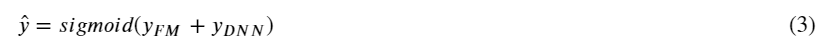


Parameter w의 길이는 num_feature(27)이며, Parameter V의 shape은 num_field(102), embedding_size(사용자 지정)이다. 

call 함수에서 보면 알 수 있듯이, 이 V행렬은 One-Hot 인코딩된 데이터에 곱해지는 구조이기 때문에 tf.nn.embedding_lookup이라는 함수를 통해 행이 복제/ 즉, 앞서 생성한 field_index의 정보를 참조하여, 같은 field에서 나온 feature일 경우, 같은 Embedding Row(V의 Row)를 공유. 

num_feature=len(field_index) = num_field=len(field_dict) # columns의 수

In [ ]:
class FM_layer(tf.keras.layers.Layer):
    def __init__(self, num_feature, grouped_field, embedding_size, feature_index):
        super(FM_layer, self).__init__()
        self.embedding_size = embedding_size    # k: 임베딩 벡터의 차원(크기)
        self.num_feature = num_feature          # f: 원래 feature 개수
        self.grouped_field = grouped_field      # m: grouped field 개수
        self.feature_index = feature_index      # 인코딩된 X의 칼럼들이 본래 어디 소속이었는지

        # Parameters of FM Layer
        # w: capture 1st order interactions (linear - num_feature 만큼의 크기를 가진 벡터)
        # V: capture 2nd order interactions
        # tf.Variable: 모델링에서 weight나 bias와 같은 변수 값을 초기화하는 훈련가능한 변수
        self.w = tf.Variable(tf.random.normal(shape=[num_feature], mean=0.0, stddev=1.0)
                           , name='w'
                            )
        self.V = tf.Variable(tf.random.normal(shape=(grouped_field, embedding_size), 
                                              mean=0.0, stddev=0.01)
                           , name='V'
                            )

    def call(self, inputs):
        # try:
          # print(f"input vector's shape: {inputs.shape}") #input vector's shape: (256, 101)
        x_batch = tf.reshape(tf.expand_dims(inputs, axis=-1), [-1, self.num_feature, 1]) #-1: 가로 vector로 생성, self.feature_index 만큼의 행, 1열
        # print(f"X's Batch Shape: {x_batch.shape}") #X's Batch Shape: (256, 101, 1)                 
        # except ValueError as exception:
        #   print(exception)
        
        # Parameter V를 feature_index에 맞게 복사하여 num_feature에 맞게 늘림 (field 수만큼 embedding)
        embeds = tf.nn.embedding_lookup(params=self.V, ids=self.feature_index)
        # print(f"Embedding Layer Shape: {embeds.shape}") #Embedding Layer Shape: (101, 10)
        
        # Deep Component에서 쓸 Input
        # (batch_size, num_feature, embedding_size)
        # order-2 layer (inner product of respective feature latent vectors)
        vector_inputs = tf.math.multiply(x_batch, embeds) 
        # print(f'Input Layer Shape: {vector_inputs.shape}') #Input Layer Shape: (256, 101, 10)

        # (batch_size, ) -> order-1 layer (linear interactions among features)
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1, keepdims=False)

        # (batch_size, ) -> order-2 features (inner product units)
        # tf.math.pow(tf.matmul(inputs, self.V), 2) - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)
        # tf.matmul: 행렬의 곱셈
        interactions = 0.5 * tf.subtract(
            tf.square(tf.reduce_sum(vector_inputs, [1, 2])),
            tf.reduce_sum(tf.square(vector_inputs), [1, 2])
        )
        
        # sigmoid function for CTR prediction
        linear_terms = tf.reshape(linear_terms, [-1, 1]) #벡터 -> tensor화된 벡터로 변환
        interactions = tf.reshape(interactions, [-1, 1])
        y_fm = tf.concat([linear_terms, interactions], 1)

        return y_fm, vector_inputs

Embedding Layer 구조에는 두 가지 흥미로운 점이 있다. 

`an embedding layer to compress the input vector to a low-dimensional,dense real-value vector before further feeding into the first hidden layer`

1) **다른 field의 input vector의 길이는 다를 수 있지만 embedding은 같은 크기(k)**이다. (역자 예시: gender field는 보통 length가 남, 여 2인 반면 국적이나 나이 field의 길이는 더 길다. 하지만 embedding시에는 똑같이 k=5차원 벡터로 임베딩 된다.) 


FM component와 Deep component가 같은 feature embdding을 공유한다는 점이 주목할 만 한데 이 덕분에 두 가지 중요한 장점을 갖게 된다. 

1) raw feature로부터 낮은 차원과 높은 차원의 피쳐 상호작용을 둘 다 학습할 수 있다. 2) Wide & Deep 모델과 다르게 input의 직접적인 feature engineering이 필요하지 않다.

2) **FM에서의 latent feature vector(V)가 이 네트워크의 가중치로 사용되고 input field vector를 압축하는 데 사용되고 학습**된다. [Zhang et al., 2016]에서는 V가 FM에 의해 pre-trained되고 이 값을 초기값으로 사용한다. 이번 논문에서는 이런 방법을 사용하는 대신 FM을 DNN과 별개로 학습 구조에 포함한다. 이렇게 함으로써 pre-training을 할 필요가 없어지고 전체 네트워크를 end-to-end로 학습할 수 있게 된다. Embedding Layer의 output을 다음과 같이 표현하면:

> $a^{(0)}$ = $[e_1, e_2, ..., e_m]$

$e_i$는 i번째 field의 임베딩을 나타내고 m은 field의 수를 나타낸다.

$a^{(0)}$은 DNN에 들어가서 다음과 같이 forward process를 거친다:

> $a^{(l+1)}$ = $\sigma (W^{(l)}a^{(l)}+b^{(l)})$

- $a^{(l)}$은 l번째 layer의 output
- $\sigma$: 활성화함수 & $l$: layer depth & $b^{(l)}$: l번째 layer bias

the sigmoid function for CTR prediction: 

> $y_{DNN}$ = $\sigma(W^{|H|+1} \times a^H + b^{|H|+1})$ 

, where |H| is the number of hidden layers.

출처: https://orill.tistory.com/entry/논문-리뷰-DeepFM-A-Factorization-Machine-based-Neural-Network-for-CTR-Prediction [이제 며칠 후엔]

In [ ]:
class DeepFM(tf.keras.Model):
    def __init__(self, num_feature, grouped_field, embedding_size, feature_index):
        super(DeepFM, self).__init__()
        self.embedding_size = embedding_size    # k: 임베딩 벡터의 차원(크기)
        self.num_feature = num_feature          # f: 원래 feature 개수
        self.grouped_field = grouped_field      # m: grouped field 개수
        self.feature_index = feature_index      # 인코딩된 X의 칼럼들이 본래 어디 소속이었는지 (칼럼 인덱스)

        self.fm_layer = FM_layer(num_feature, grouped_field, embedding_size, feature_index)
        
        self.hidden_layer1 = tf.keras.layers.Dense(units=64, activation='relu') #tf.keras.layers.Dense(레이어 사이즈, 활성화 함수): 인공신경망 구조를 구현시켜주는 함수
        self.dropout1 = tf.keras.layers.Dropout(rate=0.4)
        self.hidden_layer2 = tf.keras.layers.Dense(units=32, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(rate=0.2)
        self.hidden_layer3 = tf.keras.layers.Dense(units=16, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(rate=0.1)
        self.hidden_layer4 = tf.keras.layers.Dense(units=2, activation='relu')

        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

    def __repr__(self):
        return "DeepFM Model: # Field: {}, # Feature: {}, Embedding: {}".format(self.grouped_field, self.num_feature, self.embedding_size)
    
    def call(self, inputs):
        # 1) FM Component: (num_batch, 2)
        y_fm, vector_inputs = self.fm_layer(inputs)
        # print(f'Sigmoid Function shape: {y_fm.shape}') #Sigmoid Function shape: (256, 2)
        # print(f'input vector shape: {vector_inputs.shape}') #input vector shape: (256, 101, 10)

        # retrieve Dense Vectors: (num_batch, num_feature*embedding_size)
        vector_inputs = tf.reshape(vector_inputs, [-1, self.num_feature*self.embedding_size])

        # 2) Deep Component
        y_deep = self.hidden_layer1(vector_inputs)
        y_deep = self.dropout1(y_deep)
        y_deep = self.hidden_layer2(y_deep)
        y_deep = self.dropout2(y_deep)
        y_deep = self.hidden_layer3(y_deep)
        y_deep = self.dropout3(y_deep)
        y_deep = self.hidden_layer4(y_deep)

        # Concatenation
        y_pred = tf.concat([y_fm, y_deep], 1)
        y_pred = self.output_layer(y_pred)
        y_pred = tf.reshape(y_pred, [-1, ])
        
        return y_pred

# Model Training

In [ ]:
def training_per_batch(model, x, y, opt, train_acc, train_auc):
  with tf.GradientTape() as gt: #GradientTapes can be nested to compute higher-order derivatives. (자동으로 미분 실행.)
      y_pred = model(x)
      loss = tf.keras.losses.binary_crossentropy(from_logits=False, y_true=y, y_pred=y_pred)

  grads = gt.gradient(target=loss, sources=model.trainable_variables)

  # apply_gradients()를 통해 processed gradients를 적용함
  opt.apply_gradients(zip(grads, model.trainable_variables))

  # accuracy & auc 성능
  train_acc.update_state(y, y_pred)
  train_auc.update_state(y, y_pred)

  return loss

In [ ]:
# 반복 학습 함수
def training(epoch):
    # X_train, X_test, y_train, y_test = split_data()
    train_ds, test_ds, vec_dict, feature_index = split_data()
    
    model = DeepFM(embedding_size= EMBEDDING_SIZE, 
                   num_feature=len(feature_index),
                   grouped_field=len(vec_dict), 
                   feature_index=feature_index)
    '''
        self.embedding_size = embedding_size    # k: 임베딩 벡터의 차원(크기)
        self.num_feature = num_feature          # f: 원래 feature 개수 (shape[1]에 해당)
        self.grouped_field = grouped_field              # m: grouped field 개수
        self.field_index = field_index          # 인코딩된 X의 칼럼들이 본래 어디 소속이었는지 (칼럼 인덱스)
        
        print('X shape: {}'.format(X_modified.shape))  
        print('# of Feature: {}'.format(len(field_index)))
        print('# of Field: {}'.format(len(field_dict)))
    '''
    # Momentum 장점 + AdaGrad 장점 = Adam (모멘텀 방식보다 좌우 흔들림이 덜 함. 좌우흔들림이 덜 함.)
    # 추가로 논문에 나온 대로 FTRL 기법 사용
    opt = tf.keras.optimizers.Adam(learning_rate=0.01) #learning_rate은 별도로 조절
    ''' 
    var1 = tf.Variable(10.0)
    loss = lambda: (var1 ** 2)/2.0       # d(loss)/d(var1) == var1
    step_count = opt.minimize(loss, [var1]).numpy()
    # The first step is `-learning_rate*sign(grad)`
    var1.numpy(): 9.9
    '''
  
    start = perf_counter()
    print("Start Training: Batch Size: {}, Embedding Size: {}".format(BATCH_SIZE, EMBEDDING_SIZE))

    for i in range(epoch):
      train_acc = BinaryAccuracy(threshold=0.5) #threshold값도 조절 (0.4~0.6 사이 값)
      train_auc = AUC()
      loss_history = []

      for x, y in train_ds:
          loss = training_per_batch(model, x, y, opt, train_acc, train_auc)
          loss_history.append(loss)
      print("Epoch {}: 누적 Loss: {:.4f}, Acc: {:.4f}, AUC: {:.4f}".format(i+1, np.mean(loss_history), train_acc.result().numpy(), train_auc.result().numpy()))
    
    print("End of Training")
    test_acc = BinaryAccuracy(threshold=0.5)
    test_auc = AUC()
    for x, y in test_ds:
        y_pred = model(x)
        test_acc.update_state(y, y_pred)
        test_auc.update_state(y, y_pred)
    
    print("테스트 ACC: {:.4f}, AUC: {:.4f}".format(test_acc.result().numpy(), test_auc.result().numpy()))
    print("Batch Size: {}, Embedding Size: {}".format(BATCH_SIZE, EMBEDDING_SIZE))
    print(f"걸린 시간: {((perf_counter() - start)//60}분 {round((perf_counter() - start)%60, 2)}초"))
    print()

하이퍼 파라미터 목록:
- batch size
- embedding size
- threshold
- learning rate
- epoch
- activation function
- 

In [ ]:
if __name__ == '__main__':
  training(10)

---- Data info ----
{'obj': ['user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']}
Data Frame shape: (842463, 101)
# of Feature: 101
# of Field: 27
Modified DF columns: Index(['user_gender/F', 'user_gender/M', 'imp_hour/0', 'imp_hour/1',
       'imp_hour/2', 'imp_hour/3', 'imp_hour/4', 'imp_hour/5', 'imp_hour/6',
       'imp_hour/7',
       ...
       'adver_favorite_count', 'adver_grade', 'adver_item_count',
       'adver_interest', 'adver_review_count', 'adver_comment_count',
       'adver_pay_count', 'adver_parcel_post_count', 'adver_tra

# SMOTE 사용하여 불균형 데이터 확인하기

In [ ]:
# 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
from imblearn.over_sampling import SMOTE

file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)

vec_dict, feature_index, modified_df = preprocessing()

X = modified_df#.astype('float')
y = df['click_label']

# SMOTE 기법 적용 전
print(y.value_counts())

oversample = SMOTE(random_state=2022)
X, y = oversample.fit_resample(X, y)

# SMOTE 기법 적용 후
print(y.value_counts())

---- Data info ----
{'obj': ['user_gender', 'user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_coun